In [1]:
import numpy as np

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from shutil import copyfile

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Assign training and validation set directories
base_dir = '/content/gdrive/MyDrive/CAPSTONE/Eyelid'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with training cat pictures
train_NormalEyelid_dir = os.path.join(train_dir, 'NormalEyelid')
train_TiredEyelid_dir = os.path.join(train_dir, 'TiredEyelid')

# Directory with training dog pictures
test_NormalEyelid_dir = os.path.join(test_dir, 'NormalEyelid')
test_TiredEyelid_dir = os.path.join(test_dir, 'TiredEyelid')

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=False,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 680 images belonging to 2 classes.
Found 229 images belonging to 2 classes.


In [11]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('eyelid_labels.txt', 'w') as f:
  f.write(labels)

In [13]:
!cat eyelid_labels.txt
print (train_generator.class_indices)

NormalEyelid
TiredEyelid{'NormalEyelid': 0, 'TiredEyelid': 1}


In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=20,
      epochs=25, #25 aja pas run dr awal, takut overfit
      validation_data=validation_generator,
      validation_steps=10,
      verbose=1)


Epoch 1/25
20/20 [==============================] - 124s 6s/step - loss: 0.7022 - accuracy: 0.7075 - val_loss: 0.5719 - val_accuracy: 0.7600
Epoch 2/25
20/20 [==============================] - 42s 2s/step - loss: 0.5940 - accuracy: 0.7375 - val_loss: 0.5585 - val_accuracy: 0.7500
Epoch 3/25
20/20 [==============================] - 33s 2s/step - loss: 0.5510 - accuracy: 0.7525 - val_loss: 0.5641 - val_accuracy: 0.7500
Epoch 4/25
20/20 [==============================] - 33s 2s/step - loss: 0.5628 - accuracy: 0.7300 - val_loss: 0.6027 - val_accuracy: 0.6850
Epoch 5/25
20/20 [==============================] - 33s 2s/step - loss: 0.5104 - accuracy: 0.7650 - val_loss: 0.6069 - val_accuracy: 0.6700
Epoch 6/25
20/20 [==============================] - 33s 2s/step - loss: 0.5267 - accuracy: 0.7475 - val_loss: 0.5872 - val_accuracy: 0.6950
Epoch 7/25
20/20 [==============================] - 34s 2s/step - loss: 0.4939 - accuracy: 0.7700 - val_loss: 0.5926 - val_accuracy: 0.7100
Epoch 8/25
20/20 [=

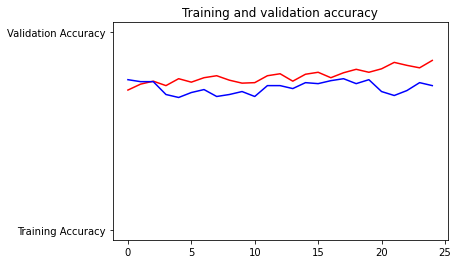

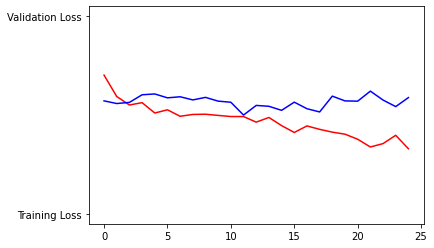

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0][0])
  
  if classes[0][0]>0.5:
    print(fn + " has a normal eyelid")
  else:
    print(fn + " probably experienced heavy eyelid")
 

Saving 19_0_3_20170104214230141.jpg.chip.jpg to 19_0_3_20170104214230141.jpg.chip.jpg
0.6182094
19_0_3_20170104214230141.jpg.chip.jpg has a normal eyelid


In [14]:
model.save("/content/gdrive/MyDrive/CAPSTONE/eyelid_model_v1.h5")